In [2]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 11.8 MB/s eta 0:00:00
     ━━━━

In [3]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [4]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [5]:
samsum = load_dataset('samsum')
samsum

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [6]:
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [7]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

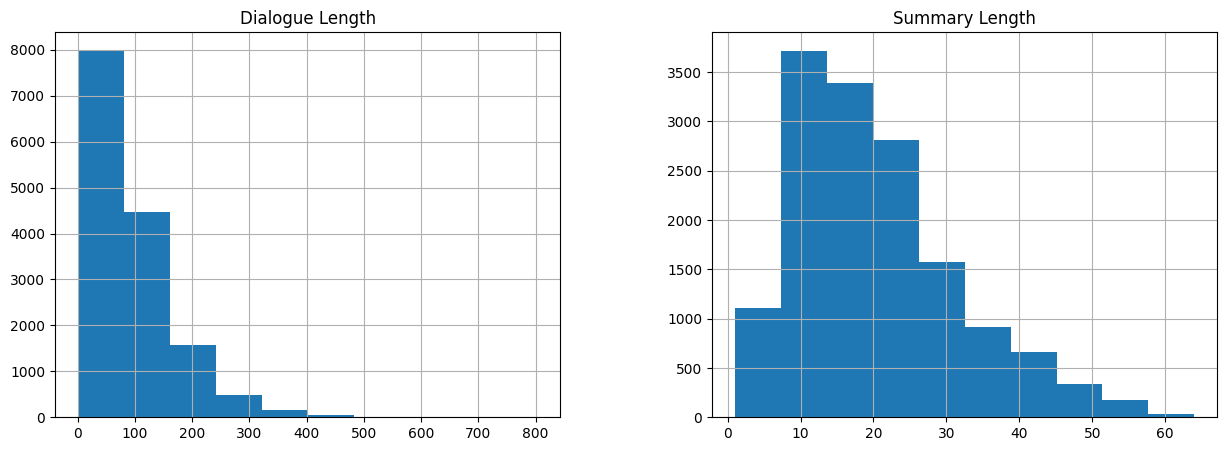

In [8]:
import pandas as pd

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(15,5))
# 500<512 which is min token size required, so suitable for all models

In [9]:
# lets build Data Collator

def get_feature(batch):
  encodings = tokenizer(batch['dialogue'], text_target=batch['summary'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [10]:
samsum_pt = samsum.map(get_feature, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [11]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [14]:
columns = ['input_ids', 'labels', 'attention_mask']
samsum_pt.set_format(type='torch', columns=columns)
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [15]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_samsum',
    num_train_epochs=1,
    warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = samsum_pt['train'], eval_dataset = samsum_pt['validation'])

In [19]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=230, training_loss=1.4692797121794328, metrics={'train_runtime': 1746.3249, 'train_samples_per_second': 8.436, 'train_steps_per_second': 0.132, 'total_flos': 8868706279096320.0, 'train_loss': 1.4692797121794328, 'epoch': 1.0})

In [20]:
trainer.save_model('bart_samsum_model')

In [21]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model='bart_samsum_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 128}

custom_dialogue="""
Laxmi Kant: what work you planning to give Tom?
Juli: i was hoping to send him on a business trip first.
Laxmi Kant: cool. is there any suitable work for him?
Juli: he did excellent in last quarter. i will assign new project, once he is back.
"""
print(pipe(custom_dialogue, **gen_kwargs))

Your max_length is set to 128, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)


[{'summary_text': 'Juli wants to send Tom on a business trip first. She will assign him a new project once he is back. Tom did excellent in last quarter and she wants to give him more work. Laxmi Kant wants to know if there is any suitable work for him.'}]


In [22]:
!zip bart_samsum.zip -r bart_samsum_model/

  adding: bart_samsum_model/ (stored 0%)
  adding: bart_samsum_model/generation_config.json (deflated 47%)
  adding: bart_samsum_model/model.safetensors (deflated 7%)
  adding: bart_samsum_model/merges.txt (deflated 53%)
  adding: bart_samsum_model/special_tokens_map.json (deflated 52%)
  adding: bart_samsum_model/vocab.json (deflated 59%)
  adding: bart_samsum_model/config.json (deflated 61%)
  adding: bart_samsum_model/tokenizer.json (deflated 72%)
  adding: bart_samsum_model/tokenizer_config.json (deflated 76%)
  adding: bart_samsum_model/training_args.bin (deflated 51%)
